In [1]:
import json
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 30]
import pandas as pd

%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append("./utils")
import dataFiltering as data_filter 
from utils import misc




2025-07-15 11:52:07.945667: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 11:52:08.102428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-15 11:52:08.143916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-15 11:52:08.163714: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 11:52:08.307174: I tensorflow/core/platform/cpu_feature_guar

##### Efficiency evaluation for single harvest day for debug purposes. SCROLL down to compute efficiency for all harvest days.

In [ ]:
class_results_path="/home/uddhav/WorkerActivityRecognitionEfficiencyEstimation/results/SantaMaria/classification_results/4-17-24_classification.csv"
break_log_path="/home/uddhav/WorkerActivityRecognitionEfficiencyEstimation/datasets/SantaMaria/break_log/4-17-24_break_log.csv"

class_data=pd.read_csv(class_results_path)
break_data=pd.read_csv(break_log_path)



In [95]:
print(class_data.head(5))
print("--------------------------")
print(break_data.head(5))

  harvest_date  cart_id       stamps  raw_mass  pred_status
0      4-17-24        1  307837700.0  0.081084          0.0
1      4-17-24        1  307837800.0  0.081135          0.0
2      4-17-24        1  307837900.0  0.081140          0.0
3      4-17-24        1  307838000.0  0.081080          0.0
4      4-17-24        1  307838100.0  0.081089          0.0
--------------------------
  harvest_date  cart_id  no_breaks
0      4-17-24        1          0
1      4-17-24        2          0
2      4-17-24        4          0
3      4-17-24        6          0
4      4-17-24        8          0


Randomly selected cart_id: 28


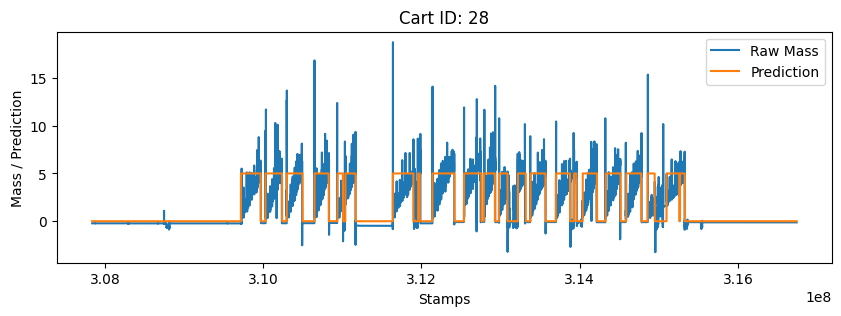

In [103]:
import random

# plotting the classification results
carts=list(class_data['cart_id'].unique())
# Select a random cart_id from the list
random_cart_id = random.choice(carts)
random_cart_id=28
print(f"Randomly selected cart_id: {random_cart_id}")

# Plot for the random cart
cart_data = class_data[class_data["cart_id"] == random_cart_id].reset_index(drop=True)
plt.figure(figsize=(10, 3))
plt.plot(cart_data["stamps"], cart_data["raw_mass"], label="Raw Mass")
plt.plot(cart_data["stamps"], cart_data["pred_status"]*5, label="Prediction")
plt.title(f"Cart ID: {random_cart_id}")
plt.xlabel("Stamps")
plt.ylabel("Mass / Prediction")
plt.legend()
plt.show()


In [104]:
# removing cart data before the start and after the end of harvest
start_idx=cart_data[cart_data["pred_status"]==1].index[0] #index before the first pick
end_idx=cart_data[cart_data["pred_status"]==1].index[-1] #index after the last pick
cart_data=cart_data[start_idx:end_idx+1].reset_index(drop=True) # resetting the index

In [105]:
cart_data['datetime_pacific']=cart_data.apply(misc.compute_datetime, axis=1)
cart_data

,harvest_date,cart_id,stamps,raw_mass,pred_status,datetime_pacific
0,4-17-24,28,309717700.0,-0.226194,1.0,2024-04-17 07:01:38.700000-07:00
1,4-17-24,28,309717800.0,-0.226286,1.0,2024-04-17 07:01:38.800000-07:00
2,4-17-24,28,309717900.0,-0.226223,1.0,2024-04-17 07:01:38.900000-07:00
3,4-17-24,28,309718000.0,-0.226286,1.0,2024-04-17 07:01:39-07:00
4,4-17-24,28,309718100.0,-0.226260,1.0,2024-04-17 07:01:39.100000-07:00
...,...,...,...,...,...,...
56095,4-17-24,28,315327400.0,-0.098468,1.0,2024-04-17 08:35:08.400000-07:00
56096,4-17-24,28,315327500.0,-0.098796,1.0,2024-04-17 08:35:08.500000-07:00
56097,4-17-24,28,315327600.0,-0.098179,1.0,2024-04-17 08:35:08.600000-07:00
56098,4-17-24,28,315327700.0,-0.097576,1.0,2024-04-17 08:35:08.700000-07:00


In [110]:
pred_pick_list,_=data_filter.get_grouped_class_lengths(cart_data,"pred_status",1)
pred_pick_durations=misc.calculate_durations(pred_pick_list, cart_data)
pred_pick_time=np.sum(pred_pick_durations)

no_breaks=list(break_data[break_data["cart_id"]==random_cart_id]["no_breaks"])[0]
print(f"Number of breaks: {no_breaks}")
pred_no_pick_list,average_break=data_filter.get_grouped_class_lengths(cart_data,"pred_status",0)
pred_no_pick_durations=misc.calculate_durations(pred_no_pick_list, cart_data)
pred_no_pick_durations=misc.replace_largest_breaks_with_median(pred_no_pick_durations, no_breaks)
pred_no_pick_time=np.sum(pred_no_pick_durations)
print(f"predicted pick time: {pred_pick_time} minutes")
print(f"predicted no pick time: {pred_no_pick_time} minutes")

Number of breaks: 1
predicted pick time: 57.300000000000004 minutes
predicted no pick time: 28.298333333333336 minutes


#### Following plots are just for visualization of the breaks and how they are identified and handled


Text(0.5, 1.0, 'Break Mask Identification')

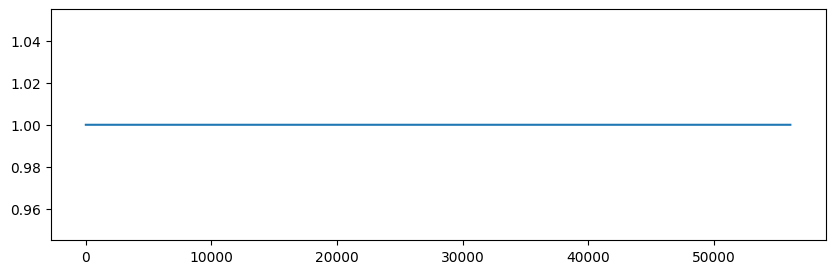

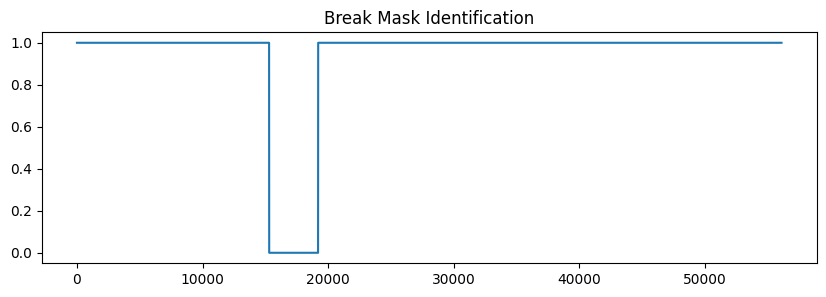

In [107]:
breaks_list = sorted(pred_no_pick_list, key=lambda x: x[1], reverse=True)
pick_mask=np.full(np.shape(cart_data)[0],1) 
plt.figure(figsize=(10, 3))
plt.plot(pick_mask)
breaks=0
while breaks < no_breaks:
    start_idx=breaks_list[breaks][0]+int(average_break)
    end_idx=breaks_list[breaks][0]+breaks_list[breaks][1] 
    pick_mask[start_idx:end_idx]=0 # data within the breaks classified as zero and removed from the plot
    breaks +=1
plt.figure(figsize=(10, 3))
plt.plot(pick_mask)
plt.title("Break Mask Identification")

Text(0.5, 1.0, 'Cart data after breaks removed')

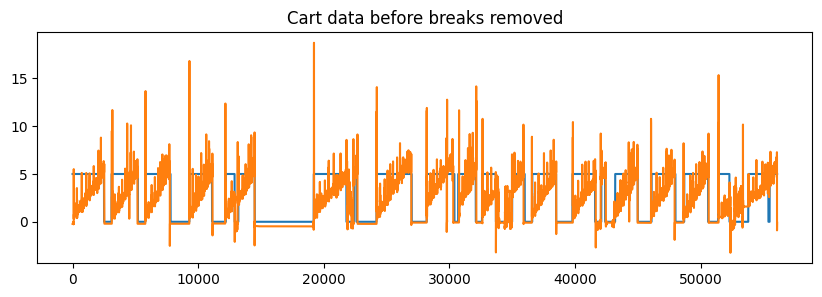

<Figure size 1000x300 with 0 Axes>

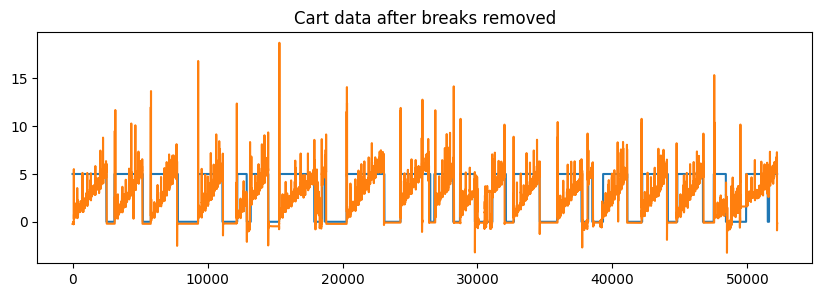

In [108]:
plt.figure(figsize=(10,3))
plt.plot(cart_data["pred_status"]*5)
plt.plot(cart_data["raw_mass"])
plt.title("Cart data before breaks removed")

plt.figure(figsize=(10,3))
pick_mask = pick_mask.astype(bool) 
cart_data = cart_data[pick_mask != 0].reset_index(drop=True)
plt.figure(figsize=(10,3))
plt.plot(cart_data["pred_status"]*5)
plt.plot(cart_data["raw_mass"])
plt.title("Cart data after breaks removed")

-----------------------------------------------------------------------------------------

## Efficiency evaluation for entire harvest season

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 30]
import pandas as pd

%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.stats as stats
import seaborn as sns

sys.path.append("./utils")
import dataFiltering as data_filter 
from utils import misc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
class_results_dir="/home/uddhav/WorkerActivityRecognitionEfficiencyEstimation/results/SantaMaria/class_results"
break_log_dir="/home/uddhav/WorkerActivityRecognitionEfficiencyEstimation/datasets/SantaMaria/break_log"
break_log_dir="/media/uddhav/My_Passport/00_STAVROS_LAB/Harvest_2024/datasets/PickNoPickTimeAnalysisData/SantaMaria/break_log"
class_results_files = [f for f in os.listdir(class_results_dir) if f.endswith('.csv')]
class_results_files=sorted(class_results_files)

In [147]:
picker_efficiency = {
    'harvest_date': [],
    'cart_id': [],
    'pick_time': [],
    'no_pick_time': []
}

for file in class_results_files:
    date_time=file.split("_")[0]
    class_data=pd.read_csv(os.path.join(class_results_dir, file))
    break_data=pd.read_csv(os.path.join(break_log_dir, date_time+"_break_log.csv"))

    for cart_id in list(set(class_data["cart_id"])):
        print(f"Processing harvest of {date_time} with cart id {cart_id}")

        cart_data=class_data[class_data["cart_id"]==cart_id].reset_index(drop=True) # extract data from seleted cart reset index
       
        start_idx=cart_data[cart_data["pred_status"]==1].index[0] # index before first harvest happened
        end_idx=cart_data[cart_data["pred_status"]==1].index[-1] # index after last 
        cart_data=cart_data.loc[start_idx:end_idx].reset_index(drop=True) # remove data before and after harvest

        cart_data['datetime_pacific']=cart_data.apply(misc.compute_datetime, axis=1)

        pred_pick_list,_=data_filter.get_grouped_class_lengths(cart_data,"pred_status",1)
        pred_pick_durations=misc.calculate_durations(pred_pick_list, cart_data)
        pred_pick_time=np.sum(pred_pick_durations)

        no_breaks=list(break_data[break_data["cart_id"]==cart_id]["no_breaks"])[0]
        print(f"Number of breaks: {no_breaks}")
        pred_no_pick_list,average_break=data_filter.get_grouped_class_lengths(cart_data,"pred_status",0)
        pred_no_pick_durations=misc.calculate_durations(pred_no_pick_list, cart_data)
        pred_no_pick_durations=misc.replace_largest_breaks_with_median(pred_no_pick_durations, no_breaks)
        pred_no_pick_time=np.sum(pred_no_pick_durations)



        print(f" Total harvest time {int(pred_pick_time+pred_no_pick_time)} mins, pick time {int(pred_pick_time)}, no pick time {int(pred_no_pick_time)}")
        print(f" Spent {(pred_pick_time*100)/(pred_pick_time+pred_no_pick_time) :0.2f} % of time picking")

        picker_efficiency["harvest_date"].append(date_time)
        picker_efficiency["cart_id"].append(cart_id)
        picker_efficiency["pick_time"].append(pred_pick_time)
        picker_efficiency["no_pick_time"].append(pred_no_pick_time)

        print("----------------------------------------------")

Processing harvest of 7-16-24 with cart id 32
Number of breaks: 2
 Total harvest time 349 mins, pick time 249, no pick time 99
 Spent 71.51 % of time picking
----------------------------------------------
Processing harvest of 7-16-24 with cart id 2
Number of breaks: 2
 Total harvest time 348 mins, pick time 266, no pick time 82
 Spent 76.49 % of time picking
----------------------------------------------
Processing harvest of 7-16-24 with cart id 4
Number of breaks: 2
 Total harvest time 346 mins, pick time 277, no pick time 68
 Spent 80.12 % of time picking
----------------------------------------------
Processing harvest of 7-16-24 with cart id 68
Number of breaks: 2
 Total harvest time 343 mins, pick time 274, no pick time 69
 Spent 79.91 % of time picking
----------------------------------------------
Processing harvest of 7-16-24 with cart id 38
Number of breaks: 2
 Total harvest time 349 mins, pick time 264, no pick time 85
 Spent 75.53 % of time picking
------------------------

In [148]:
picker_efficiency_df=pd.DataFrame(picker_efficiency)
picker_efficiency_df.head(10)

,harvest_date,cart_id,pick_time,no_pick_time
0,7-16-24,32,249.868333,99.546667
1,7-16-24,2,266.900000,82.038333
2,7-16-24,4,277.571667,68.860000
3,7-16-24,68,274.558333,69.023333
4,7-16-24,38,264.045000,85.533333
5,7-16-24,69,263.796667,82.280000
6,7-16-24,74,261.731667,91.501667
7,7-16-24,11,249.755000,98.670000
8,7-16-24,13,285.691667,61.533333
9,7-16-24,80,268.631667,75.293333


In [149]:
picker_efficiency_df.to_csv("picker_efficiency.csv", index=False)

In [13]:
# read the saved picker effieienbcy data
picker_efficiency_df=pd.read_csv("/home/uddhav/WorkerActivityRecognitionEfficiencyEstimation/results/SantaMaria/class_results/picker_efficiency_all.csv")

In [43]:
picker_efficiency_df["picking_percentage"]=(picker_efficiency_df["pick_time"]*100)/(picker_efficiency_df["pick_time"]+picker_efficiency_df["no_pick_time"])
# remove NaN values from picker_efficiency_df
picker_efficiency_df = picker_efficiency_df.dropna()

In [44]:
minutes_analyzed=np.sum(picker_efficiency_df["pick_time"]+picker_efficiency_df["no_pick_time"])
print(f"Minutes of data analyzed {minutes_analyzed}")

print(f"Hours of data analyzed {minutes_analyzed/60 :.2f}" )
print(f"Number of carritos analyzed {len(picker_efficiency_df)}")


Minutes of data analyzed 188971.74583333335
Hours of data analyzed 3149.53
Number of carritos analyzed 778


In [45]:
# Calculate Q1, Q3, and IQR for picking_percentage
Q1 = picker_efficiency_df['picking_percentage'].quantile(0.25)
Q3 = picker_efficiency_df['picking_percentage'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers using IQR method
picker_efficiency_df_no_outliers = picker_efficiency_df[(picker_efficiency_df['picking_percentage'] >= lower_bound) & 
                                                        (picker_efficiency_df['picking_percentage'] <= upper_bound)]

# Reset index
picker_efficiency_df_no_outliers.reset_index(drop=True, inplace=True)

# Print the percentage of data removed
percent_removed = (1 - len(picker_efficiency_df_no_outliers) / len(picker_efficiency_df)) * 100
print(f"Percentage of data removed: {percent_removed:.2f}%")


Percentage of data removed: 1.29%


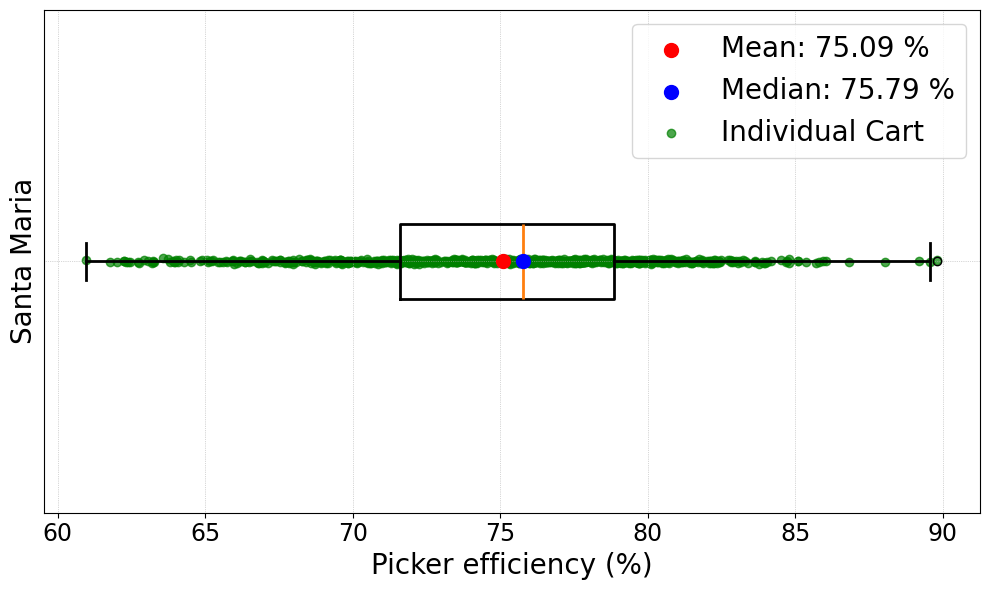

In [46]:
picking_efficiency_data=np.array(picker_efficiency_df_no_outliers["picking_percentage"])
plt.figure(figsize=(10, 6))
plt.boxplot(picking_efficiency_data, vert=False, boxprops=dict(linewidth=2),
            whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2), 
            medianprops=dict(linewidth=2))
# plt.title('Horizontal Box Plot of Weight Measurement Accuracy in Salinas, CA')
plt.xlabel('Picker efficiency (%)',fontsize=20)
plt.ylabel('Santa Maria', fontsize=20)

# Calculate mean and median
mean_accuracy = np.mean(picking_efficiency_data)
median_accuracy = np.median(picking_efficiency_data)

# Plot mean and median with increased marker size
plt.scatter(mean_accuracy, 1, color='red', label=f'Mean: {mean_accuracy:0.2f} %', zorder=5, s=100)
plt.scatter(median_accuracy, 1, color='blue', label=f'Median: {median_accuracy:0.2f} %', zorder=5, s=100)

# Scatter plot of actual data points
y_positions = np.random.normal(1, 0.002, size=len(picking_efficiency_data)) # Add some jitter for visibility
plt.scatter(picking_efficiency_data, y_positions, color='green', alpha=0.7, label='Individual Cart')

plt.legend(fontsize=20)

# Set faint dotted grid lines
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.xticks(fontsize=17)
plt.tight_layout() 

plt.savefig('results/BoxPlot_ActiveHarvestPercent.png',dpi=300)

plt.show()

In [47]:

# Compute statistics
mean = picker_efficiency_df_no_outliers["picking_percentage"].mean()
median = picker_efficiency_df_no_outliers["picking_percentage"].median()
std_dev = picker_efficiency_df_no_outliers["picking_percentage"].std()

# Compute 95% confidence interval
n = len(picker_efficiency_df_no_outliers["picking_percentage"])  # Number of data points
stderr = std_dev / np.sqrt(n)  # Standard error of the mean
ci_lower, ci_upper = stats.norm.interval(0.95, loc=mean, scale=stderr)  # 95% CI

# Print results
print(f"Mean: {mean:.2f}")
print(f"Median: {median:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")
range_min = picker_efficiency_df_no_outliers["picking_percentage"].min()
range_max = picker_efficiency_df_no_outliers["picking_percentage"].max()
print(f"Range: {range_min:.2f} to {range_max:.2f}")


Mean: 75.09
Median: 75.79
Standard Deviation: 5.19
95% Confidence Interval: (74.73, 75.46)
Range: 60.96 to 89.82


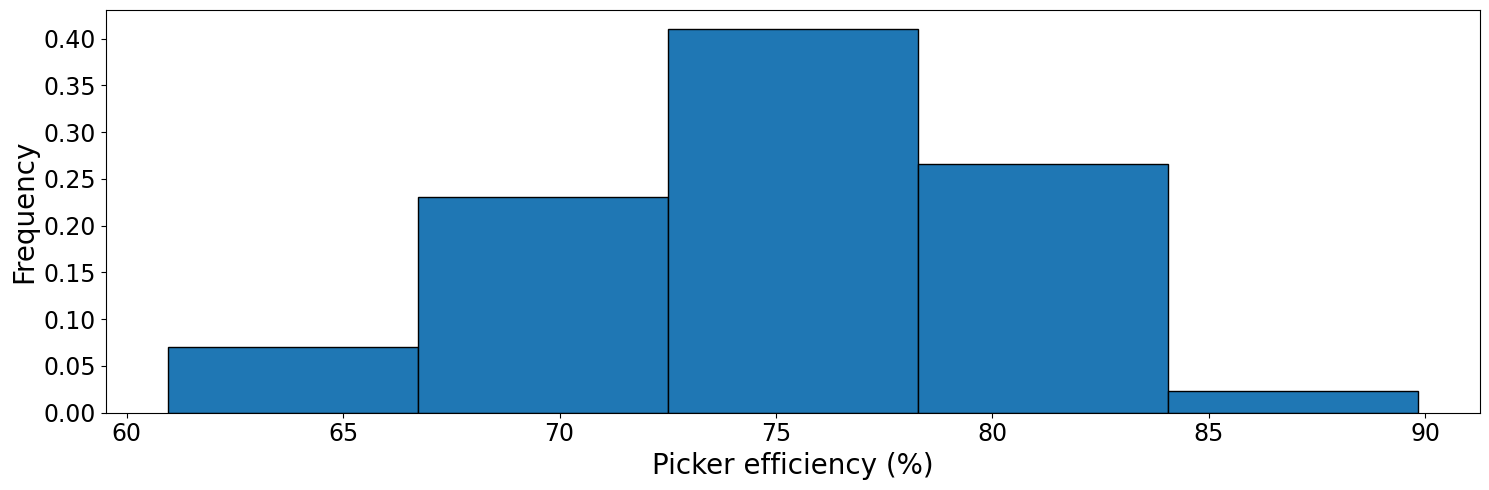

In [48]:
# Plot histogram with normalized area
plt.figure(figsize=(15, 5))
picker_efficiency_df_no_outliers["picking_percentage"].plot.hist(
    bins=5, 
    edgecolor='black', 
    weights=np.ones(len(picker_efficiency_df_no_outliers)) * (1 / len(picker_efficiency_df_no_outliers))
)
plt.ylabel('Frequency',fontsize=20)
plt.xlabel('Picker efficiency (%)', fontsize=20)
# plt.title('Frequency Distribution', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout() 

plt.savefig('results/FrequencyPlot_ActiveHarvestPercent.png',dpi=300)
plt.show()


/tmp/ipykernel_7649/3321217037.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


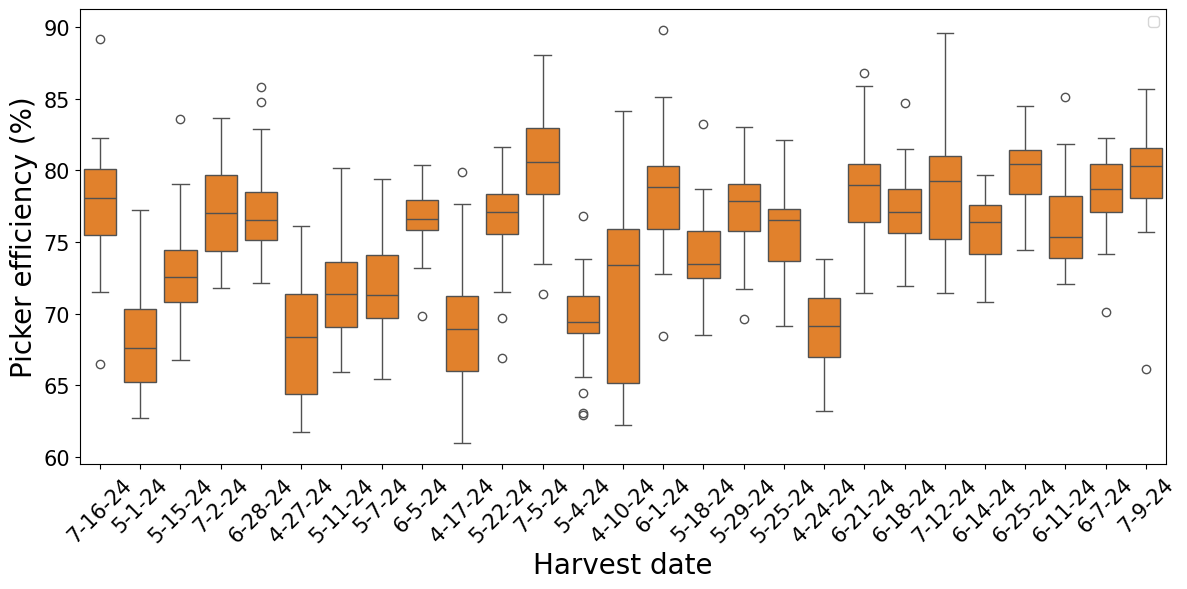

In [49]:
grouped_data = picker_efficiency_df_no_outliers.groupby('harvest_date')['picking_percentage'].agg(['mean', 'median']).reset_index()

# Create vertical box plots with mean and median data points
plt.figure(figsize=(12, 6))
sns.boxplot(x='harvest_date', y='picking_percentage', data=picker_efficiency_df_no_outliers,color='#ff7f0e')

# Add mean and median points with larger markers and distinct colors


plt.xlabel('Harvest date',fontsize=20)
plt.ylabel('Picker efficiency (%)',fontsize=20)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('results/SeasonBoxPlot_ActiveHarvestPercentage.png',dpi=300)
plt.show()

# Incorporating the Box Count Data
## Compute pick time per tray

In [50]:
picker_efficiency_df

,harvest_date,cart_id,pick_time,no_pick_time,picking_percentage
0,7-16-24,32,249.868333,99.546667,71.510477
1,7-16-24,2,266.900000,82.038333,76.489160
2,7-16-24,4,277.571667,68.860000,80.123064
3,7-16-24,68,274.558333,69.023333,79.910647
4,7-16-24,38,264.045000,85.533333,75.532427
...,...,...,...,...,...
773,7-9-24,73,189.146667,41.306667,82.075908
774,7-9-24,75,174.433333,50.445000,77.567870
775,7-9-24,76,181.106667,43.483333,80.638794
776,7-9-24,77,191.098333,34.511667,84.702953


In [51]:
# reading the tray count data
excel_path="/home/uddhav/WorkerActivityRecognitionEfficiencyEstimation/datasets/SantaMaria/harvested_trays_seasonlong.xlsx"
sheet_names=["4-10-24", "4-17-24", "4-24-24","4-27-24", "5-1-24","5-4-24","5-7-24",
            "5-11-24","5-15-24","5-18-24","5-22-24","5-25-24","5-29-24",
            "6-1-24", "6-5-24", "6-7-24", "6-11-24", "6-14-24", "6-18-24",
            "6-21-24","6-25-24", "6-28-24", "7-2-24","7-5-24", "7-9-24", "7-12-24", "7-16-24"]
print(excel_path)


/home/uddhav/WorkerActivityRecognitionEfficiencyEstimation/datasets/SantaMaria/harvested_trays_seasonlong.xlsx


In [52]:
picker_efficiency_merged = pd.DataFrame()

for date in sheet_names:
    try:
        # Read the specific sheet
        grower_df = pd.read_excel(excel_path, sheet_name=date)
        
        # Merge data
        merged_day = pd.merge(
            picker_efficiency_df[picker_efficiency_df['harvest_date'] == date],
            grower_df[['cart_id', 'no_trays']],
            on='cart_id',
            how='left'
        )
        
        # Append to the all_merged_data DataFrame
        picker_efficiency_merged = pd.concat([picker_efficiency_merged, merged_day], ignore_index=True)
        
        print(f"Processed {date}: Found {len(merged_day)} matches")
        
    except Exception as e:
        print(f"Error processing {date}: {str(e)}")

# Display the result
print(f"Total rows in merged data: {len(picker_efficiency_merged)}")


Processed 4-10-24: Found 26 matches
Processed 4-17-24: Found 30 matches
Processed 4-24-24: Found 30 matches
Processed 4-27-24: Found 31 matches
Processed 5-1-24: Found 30 matches
Processed 5-4-24: Found 27 matches
Processed 5-7-24: Found 24 matches
Processed 5-11-24: Found 32 matches
Processed 5-15-24: Found 31 matches
Processed 5-18-24: Found 29 matches
Processed 5-22-24: Found 29 matches
Processed 5-25-24: Found 29 matches
Processed 5-29-24: Found 29 matches
Processed 6-1-24: Found 29 matches
Processed 6-5-24: Found 28 matches
Processed 6-7-24: Found 24 matches
Processed 6-11-24: Found 29 matches
Processed 6-14-24: Found 28 matches
Processed 6-18-24: Found 29 matches
Processed 6-21-24: Found 30 matches
Processed 6-25-24: Found 31 matches
Processed 6-28-24: Found 35 matches
Processed 7-2-24: Found 30 matches
Processed 7-5-24: Found 31 matches
Processed 7-9-24: Found 28 matches
Processed 7-12-24: Found 32 matches
Processed 7-16-24: Found 17 matches
Total rows in merged data: 778


In [53]:
# remove NaN values from picker_efficiency_merged
picker_efficiency_merged = picker_efficiency_merged.dropna()
# picker_efficiency_merged = picker_efficiency_merged[picker_efficiency_merged["#boxes_carrito"] > 10]
picker_efficiency_merged.head()

,harvest_date,cart_id,pick_time,no_pick_time,picking_percentage,no_trays
0,4-10-24,4,43.310000,12.835000,77.139549,4.0
1,4-10-24,8,43.956667,26.661667,62.245404,6.0
2,4-10-24,10,47.423333,52.223333,47.591490,5.0
3,4-10-24,11,43.641667,18.686667,70.018985,4.0
4,4-10-24,13,45.910000,14.548333,75.936595,8.0


In [54]:
picker_efficiency_merged["pick_time_per_tray"]=picker_efficiency_merged["pick_time"]/picker_efficiency_merged["no_trays"]
picker_efficiency_merged.head()

,harvest_date,cart_id,pick_time,no_pick_time,picking_percentage,no_trays,pick_time_per_tray
0,4-10-24,4,43.310000,12.835000,77.139549,4.0,10.827500
1,4-10-24,8,43.956667,26.661667,62.245404,6.0,7.326111
2,4-10-24,10,47.423333,52.223333,47.591490,5.0,9.484667
3,4-10-24,11,43.641667,18.686667,70.018985,4.0,10.910417
4,4-10-24,13,45.910000,14.548333,75.936595,8.0,5.738750


### Removing the outlier data

In [55]:
# Calculate Q1, Q3, and IQR for pick_time_per_tray
Q1 = picker_efficiency_merged['pick_time_per_tray'].quantile(0.25)
Q3 = picker_efficiency_merged['pick_time_per_tray'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers_count = ((picker_efficiency_merged['pick_time_per_tray'] < lower_bound) | 
                  (picker_efficiency_merged['pick_time_per_tray'] > upper_bound)).sum()

print(f"Number of outliers detected using IQR method: {outliers_count}")

# Remove outliers
picker_efficiency_merged_clean = picker_efficiency_merged[
    (picker_efficiency_merged['pick_time_per_tray'] >= lower_bound) & 
    (picker_efficiency_merged['pick_time_per_tray'] <= upper_bound)
]

# Reset index
picker_efficiency_merged_clean.reset_index(drop=True, inplace=True)

print(f"Shape of dataframe after removing outliers: {picker_efficiency_merged_clean.shape}")

# Print the percentage of data removed
percent_removed = (1 - len(picker_efficiency_merged_clean) / len(picker_efficiency_merged)) * 100
print(f"Percentage of data removed: {percent_removed:.2f}%")


Number of outliers detected using IQR method: 37
Shape of dataframe after removing outliers: (733, 7)
Percentage of data removed: 4.81%


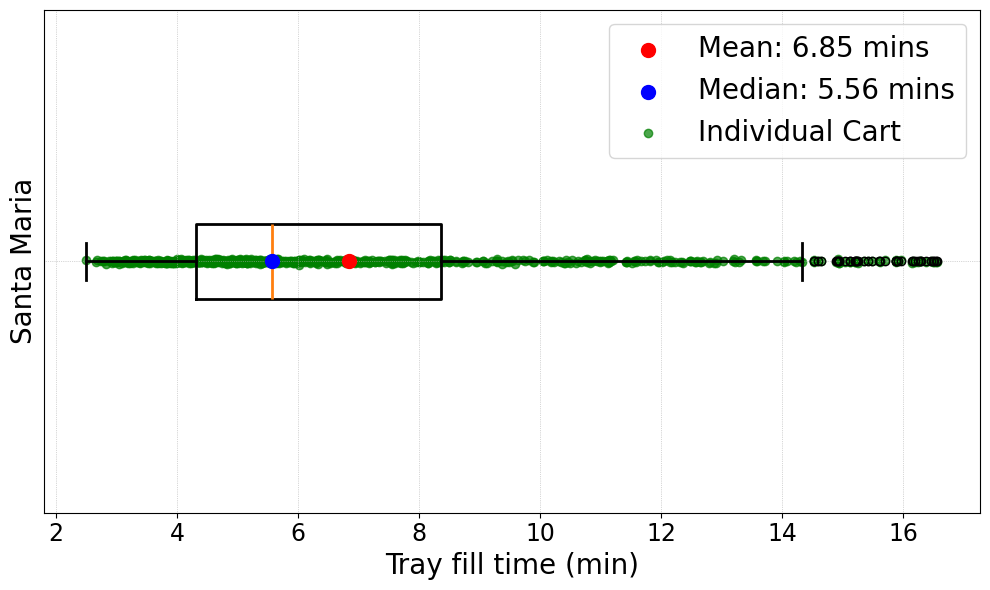

In [56]:
picking_efficiency_data=np.array(picker_efficiency_merged_clean["pick_time_per_tray"].dropna())
plt.figure(figsize=(10, 6))
plt.boxplot(picking_efficiency_data, vert=False, boxprops=dict(linewidth=2),
            whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2), 
            medianprops=dict(linewidth=2))
# plt.title('Horizontal Box Plot of Weight Measurement Accuracy in Salinas, CA')
plt.xlabel('Tray fill time (min)',fontsize=20)
plt.ylabel('Santa Maria', fontsize=20)

# Calculate mean and median
mean_accuracy = np.mean(picking_efficiency_data)
median_accuracy = np.median(picking_efficiency_data)

# Plot mean and median with increased marker size
plt.scatter(mean_accuracy, 1, color='red', label=f'Mean: {mean_accuracy:0.2f} mins', zorder=5, s=100)
plt.scatter(median_accuracy, 1, color='blue', label=f'Median: {median_accuracy:0.2f} mins', zorder=5, s=100)

# Scatter plot of actual data points
y_positions = np.random.normal(1, 0.002, size=len(picking_efficiency_data)) # Add some jitter for visibility
plt.scatter(picking_efficiency_data, y_positions, color='green', alpha=0.7, label='Individual Cart')

plt.legend(fontsize=20)

# Set faint dotted grid lines
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.xticks(fontsize=17)
plt.tight_layout() 

plt.savefig('results/BoxPlot_TrayFillRate.png',dpi=300)

plt.show()

In [57]:

# Compute statistics
mean = picker_efficiency_merged_clean["pick_time_per_tray"].mean()
median = picker_efficiency_merged_clean["pick_time_per_tray"].median()
std_dev = picker_efficiency_merged_clean["pick_time_per_tray"].std()
range_min = picker_efficiency_merged_clean["pick_time_per_tray"].min()
range_max = picker_efficiency_merged_clean["pick_time_per_tray"].max()

# Compute 95% confidence interval
n = len(picker_efficiency_merged_clean["pick_time_per_tray"])  # Number of data points
stderr = std_dev / np.sqrt(n)  # Standard error of the mean
ci_lower, ci_upper = stats.norm.interval(0.95, loc=mean, scale=stderr)  # 95% CI

# Print results
print(f"Mean: {mean:.2f}")
print(f"Median: {median:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")
print(f"Range: {range_min:.2f} to {range_max:.2f}")


Mean: 6.85
Median: 5.56
Standard Deviation: 3.44
95% Confidence Interval: (6.60, 7.10)
Range: 2.50 to 16.57


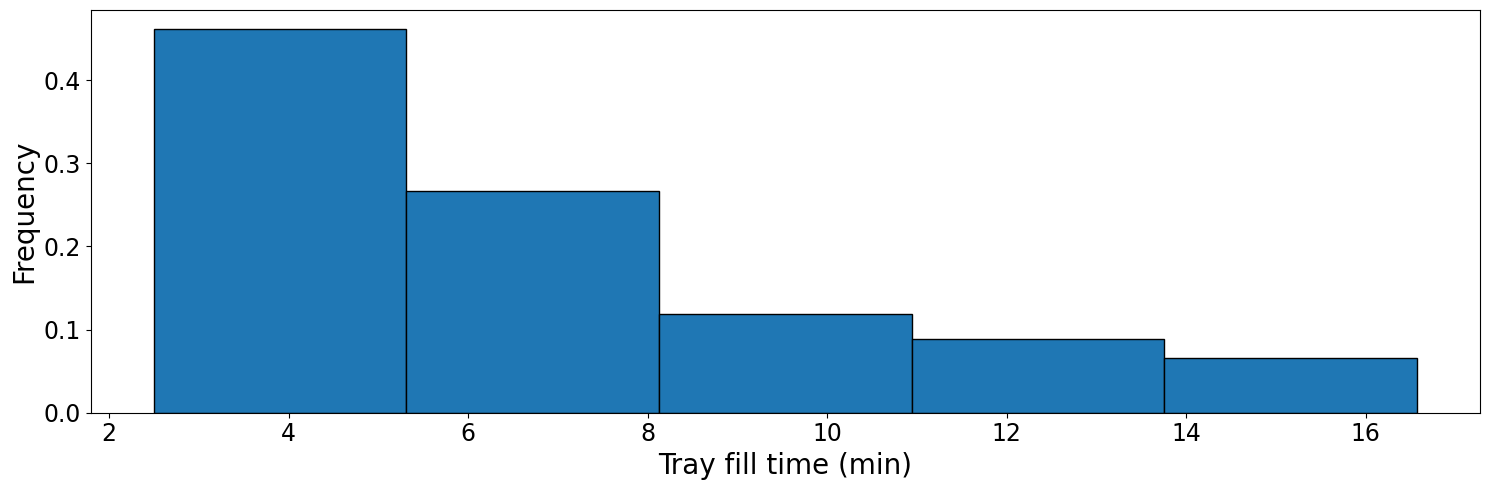

In [58]:
# Plot histogram with normalized area
plt.figure(figsize=(15, 5))
picker_efficiency_merged_clean["pick_time_per_tray"].plot.hist(
    bins=5, 
    edgecolor='black', 
    weights=np.ones(len(picker_efficiency_merged_clean)) * (1 / len(picker_efficiency_merged_clean))
)
plt.ylabel('Frequency',fontsize=20)
plt.xlabel('Tray fill time (min)', fontsize=20)
# plt.title('Frequency Distribution', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout() 

plt.savefig('results/FrequencyPlot_TrayFillRate.png',dpi=300)
plt.show()

In [59]:
# Calculate the percentage of trays filled within seven minutes
trays_within_seven_minutes = picker_efficiency_merged_clean[picker_efficiency_merged_clean["pick_time_per_tray"] <= 6]
percentage_within_seven_minutes = (len(trays_within_seven_minutes) / len(picker_efficiency_merged_clean)) * 100
print(f"Percentage of trays filled within six minutes: {percentage_within_seven_minutes:.2f}%")

Percentage of trays filled within six minutes: 55.25%


/tmp/ipykernel_7649/846337397.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


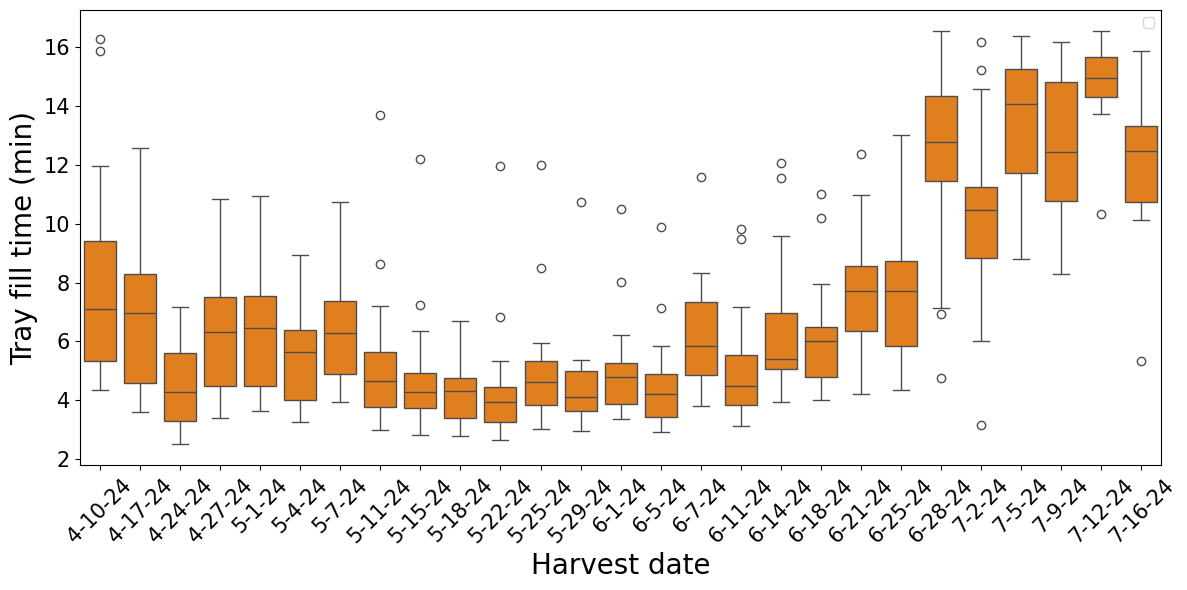

In [60]:
grouped_data = picker_efficiency_merged_clean.groupby('harvest_date')['pick_time_per_tray'].agg(['mean', 'median']).reset_index()

# Create vertical box plots with mean and median data points
plt.figure(figsize=(12, 6))
sns.boxplot(x='harvest_date', y='pick_time_per_tray', data=picker_efficiency_merged_clean,color='#ff7f00')



# Add mean and median points with larger markers and distinct colors


plt.xlabel('Harvest date',fontsize=20)
plt.ylabel('Tray fill time (min)',fontsize=20)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.tight_layout() 
plt.savefig('results/SeasonBoxPlot_TrayFillRate.png',dpi=300)
plt.show()

/tmp/ipykernel_7649/1199222567.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


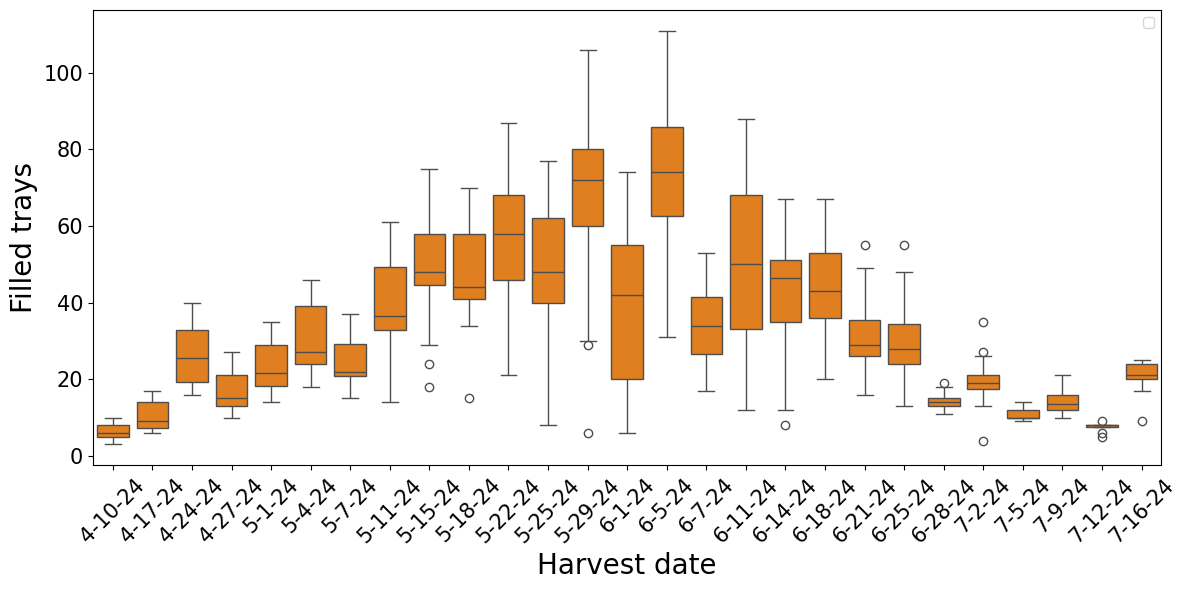

In [61]:
grouped_data = picker_efficiency_merged.groupby('harvest_date')['no_trays'].agg(['mean', 'median']).reset_index()

# Create vertical box plots with mean and median data points
plt.figure(figsize=(12, 6))
sns.boxplot(x='harvest_date', y='no_trays', data=picker_efficiency_merged_clean,color='#ff7f00')



# Add mean and median points with larger markers and distinct colors


plt.xlabel('Harvest date',fontsize=20)
plt.ylabel('Filled trays',fontsize=20)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.tight_layout() 
# plt.ylim([0, 10])
plt.savefig('results/SeasonBoxPlot_TrayFillRate.png',dpi=300)
plt.show()

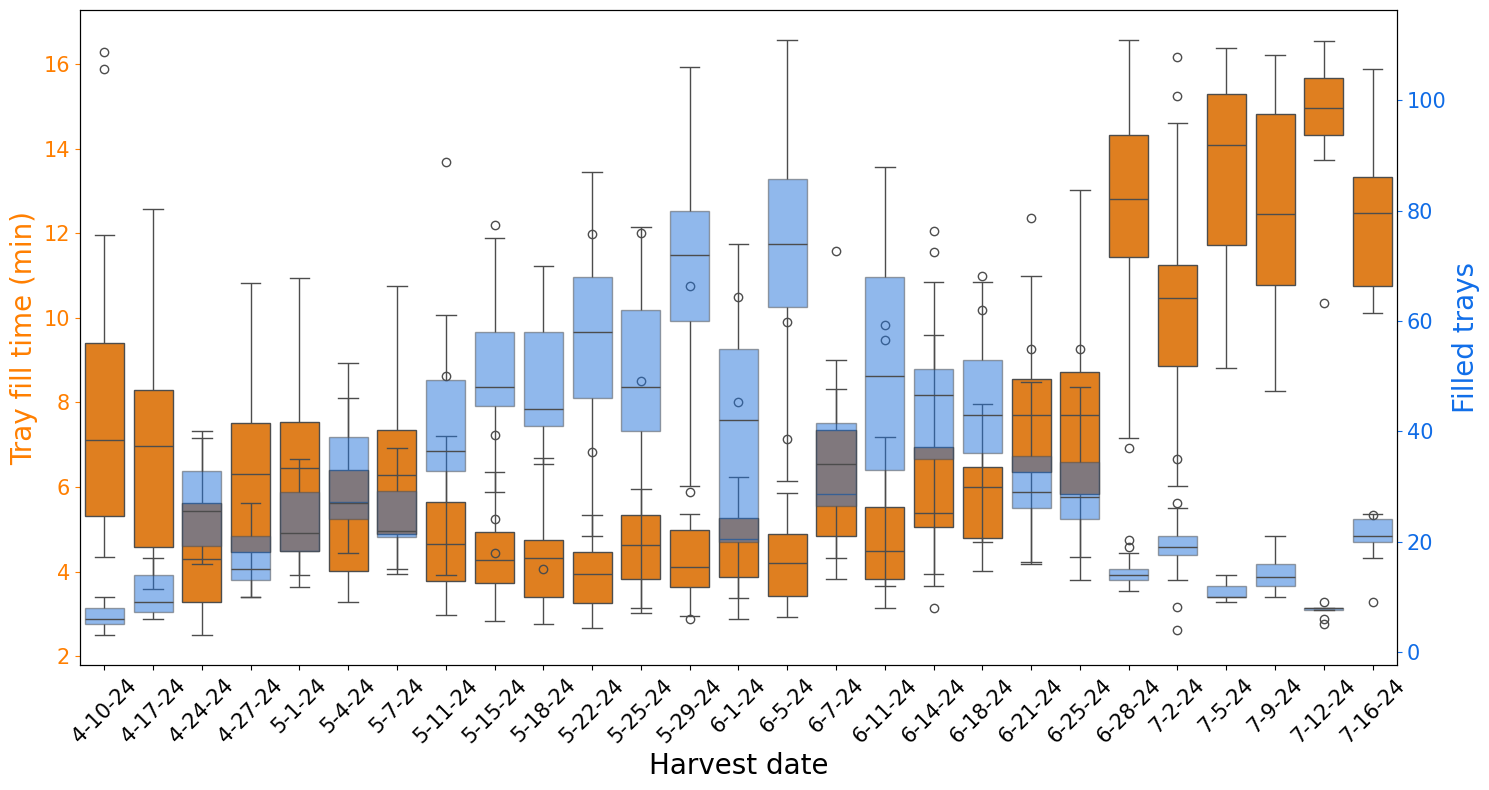

In [62]:

# Create a figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot tray fill time on the primary y-axis
box1 = sns.boxplot(
    x='harvest_date', 
    y='pick_time_per_tray', 
    data=picker_efficiency_merged_clean, 
    color='#ff7f00', 
    ax=ax1
)

# Apply transparency to the box plot elements
for patch in box1.patches:
    patch.set_alpha(1)

ax1.set_xlabel('Harvest date', fontsize=20)
ax1.set_ylabel('Tray fill time (min)', fontsize=20, color='#ff7f00')
ax1.tick_params(axis='x', rotation=45, labelsize=15)
ax1.tick_params(axis='y', labelsize=15, colors='#ff7f00')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot filled trays on the secondary y-axis
box2 = sns.boxplot(
    x='harvest_date', 
    y='no_trays', 
    data=picker_efficiency_merged_clean, 
    color="#046ffa", 
    ax=ax2
)

# Apply transparency to the second box plot elements
for patch in box2.patches:
    patch.set_alpha(0.5)

ax2.set_ylabel('Filled trays', fontsize=20, color="#106ee9")
ax2.tick_params(axis='y', labelsize=15, colors="#106ce6")

# Adjust layout and show the plot
# plt.title('Tray Fill Time and Filled Trays by Harvest Date', fontsize=22)
plt.tight_layout()
plt.savefig('results/TrayFillTimeAndFilledTraysByHarvestDate.png', dpi=300)

plt.show()


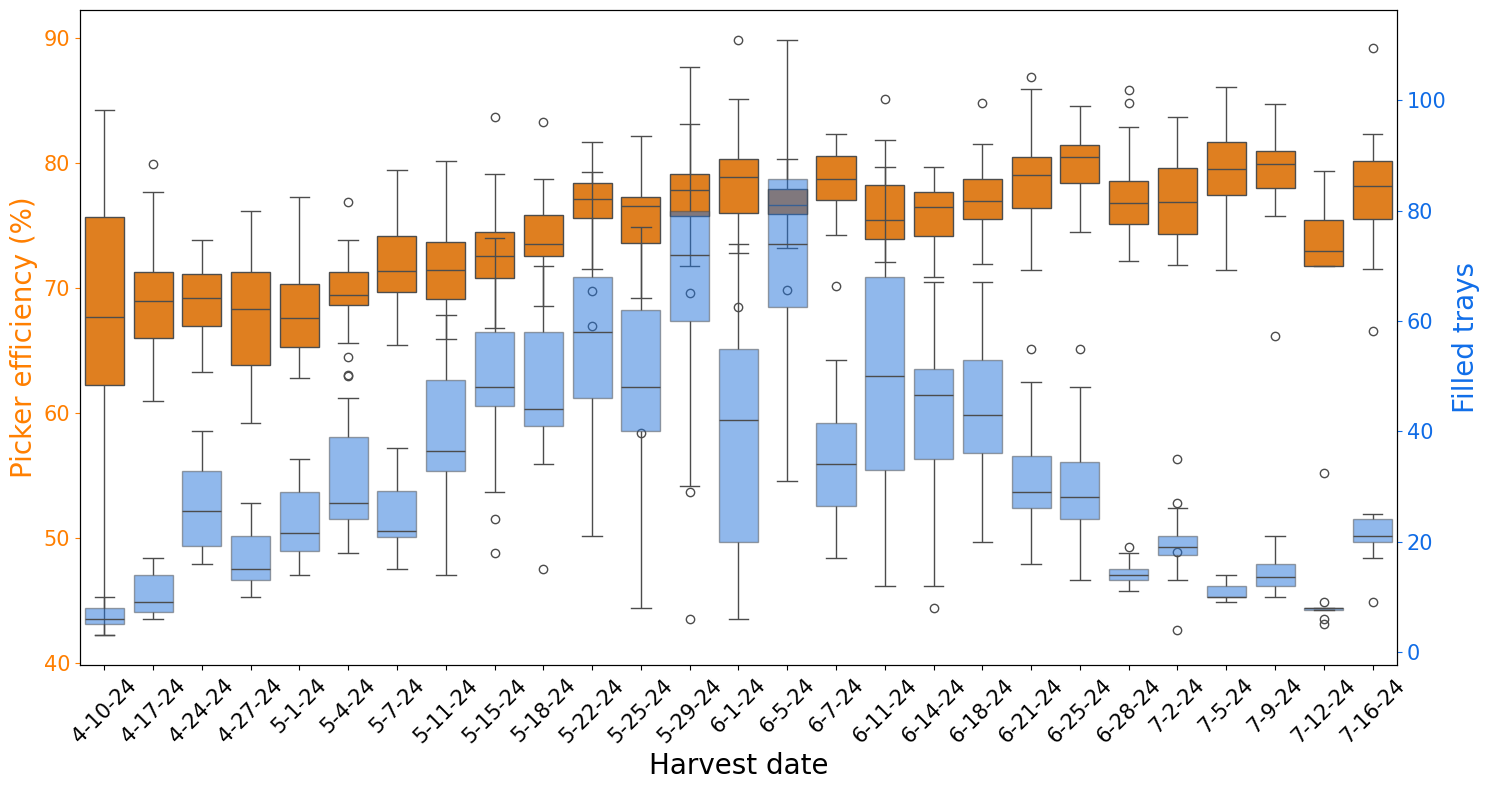

In [64]:

# Create a figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot tray fill time on the primary y-axis
box1 = sns.boxplot(
    x='harvest_date', 
    y='picking_percentage', 
    data=picker_efficiency_merged_clean, 
    color='#ff7f00', 
    ax=ax1
)

# Apply transparency to the box plot elements
for patch in box1.patches:
    patch.set_alpha(1)

ax1.set_xlabel('Harvest date', fontsize=20)
ax1.set_ylabel('Picker efficiency (%)', fontsize=20, color='#ff7f00')
ax1.tick_params(axis='x', rotation=45, labelsize=15)
ax1.tick_params(axis='y', labelsize=15, colors='#ff7f00')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot filled trays on the secondary y-axis
box2 = sns.boxplot(
    x='harvest_date', 
    y='no_trays', 
    data=picker_efficiency_merged_clean, 
    color="#046ffa", 
    ax=ax2
)

# Apply transparency to the second box plot elements
for patch in box2.patches:
    patch.set_alpha(0.5)

ax2.set_ylabel('Filled trays', fontsize=20, color="#106ee9")
ax2.tick_params(axis='y', labelsize=15, colors="#106ce6")

# Adjust layout and show the plot
# plt.title('Tray Fill Time and Filled Trays by Harvest Date', fontsize=22)
plt.tight_layout()
plt.savefig('results/PickerEfficiencyAndFilledTraysByHarvestDate.png', dpi=300)

plt.show()


### This concludes the efficiency evaluation for the entire harvest season.